In [44]:
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
%matplotlib inline

In [45]:
features = pd.read_pickle("train_features.pkl")
labels = pd.read_csv("train_labels.csv",index_col="challenge_oid")
features.index.name = "challenge_oid"
features = features.join(labels)

In [46]:
labels = features["classALeRCE"]
del features["classALeRCE"] 

In [57]:
periodic = ["RRL", "EB", "DSCT", "Ceph", "Periodic-Other"]
stochastic = ["AGN", "QSO", "YSO", "CV/Nova", "LPV", "Blazar"]
transient = ["SNIa", "SNII", "SNIbc"]

In [58]:
maps = {"SNIa":0, "SNII":1, "SNIbc":2, "RRL":3, 
             "EB":4, "DSCT":5, "Ceph":6, "Periodic-Other":7, 
             "AGN":8, "QSO":9, "YSO":10, "CV/Nova":11, "LPV":12, "Blazar":13}

colums = ["SNIa", "SNII", "SNIbc", "RRL", 
             "EB", "DSCT", "Ceph", "Periodic-Other", 
             "AGN", "QSO", "YSO", "CV/Nova", "LPV", "Blazar"]

In [59]:
def map_class(x):
    class_map = {"periodic": periodic, "stochastic": stochastic, "transient": transient}
    for i in class_map:
        if x in class_map[i]:
            return i

In [60]:
new_classes = []
for old_class in labels.values:
    new_classes.append(map_class(old_class))

In [61]:
new_classes_low = []
for old_class in labels.values:
    new_classes_low.append(maps[old_class])

In [62]:
root_le = LabelEncoder()
new_classes_encoded = root_le.fit_transform(new_classes)

In [63]:
low_le = LabelEncoder()
new_classes_low = low_le.fit_transform(new_classes_low)

In [64]:
minmax = MinMaxScaler()
minmax.fit(features)
scaled_features = minmax.transform(features)
scaled_features = scaled_features+1
scaled_features = np.nan_to_num(scaled_features)-1 

In [65]:
def loss(y_true,y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true,y_pred) + tf.keras.backend.mean(tf.keras.backend.sum(y_pred,axis=1))

In [67]:
models = []
for i in range(10):
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-5, patience=5),tf.keras.callbacks.TensorBoard(log_dir='logs')]
    inputs = tf.keras.layers.Input(len(features.columns)) 

    layer1 = tf.keras.layers.Dense(128,activation="relu")(inputs)
    layer1 = tf.keras.layers.Dropout(0.2)(layer1)
    layer2 = tf.keras.layers.Dense(64,activation="relu")(layer1)
    layer2 = tf.keras.layers.Dropout(0.2)(layer2)
    layer3 = tf.keras.layers.Dense(32,activation="relu")(layer2)
    layer3 = tf.keras.layers.Dropout(0.2)(layer3)

    out_root = tf.keras.layers.Dense(3,activation="softmax")(layer3)
    l1 = tf.keras.layers.Dense(16,activation="relu")(layer3)
    outputs = tf.keras.layers.Dense(14,activation="softmax")(l1)

    model = tf.keras.models.Model(inputs=inputs, outputs=[out_root,outputs])

    tmp_features = scaled_features.copy()
    tmp_features = np.hstack([scaled_features, np.arange(len(tmp_features)).reshape((-1,1))])   
    X_train, X_test, y_train, y_test = train_test_split(tmp_features,new_classes_low, test_size=0.2)
    
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled_low = ros.fit_resample(X_train, y_train)

    X_resampled_index = X_resampled[:,-1].astype(int)
    X_resampled_features = X_resampled[:,:-1]
    y_resampled = new_classes_encoded[X_resampled_index]

    X_test_resampled_index = X_test[:,-1].astype(int)
    X_test_resampled_features = X_test[:,:-1]
    y_test_resampled = new_classes_encoded[X_test_resampled_index]
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_resampled_features,[tf.keras.utils.to_categorical(y_resampled), 
                                tf.keras.utils.to_categorical(y_resampled_low)], 
                validation_data=(X_test_resampled_features,
                                 ( tf.keras.utils.to_categorical(y_test_resampled), tf.keras.utils.to_categorical(y_test) )
                                ),
                epochs=10, callbacks=callbacks)
    models.append(model)

Train on 127400 samples, validate on 7737 samples
Epoch 1/10
127400/127400 [==============================] - 8s 62us/sample - loss: 1.8008 - dense_111_loss: 0.2933 - dense_113_loss: 1.5073 - dense_111_accuracy: 0.8810 - dense_113_accuracy: 0.4199 - val_loss: 1.3959 - val_dense_111_loss: 0.2167 - val_dense_113_loss: 1.1790 - val_dense_111_accuracy: 0.9129 - val_dense_113_accuracy: 0.5260
Epoch 2/10
127400/127400 [==============================] - 8s 66us/sample - loss: 1.2810 - dense_111_loss: 0.1879 - dense_113_loss: 1.0931 - dense_111_accuracy: 0.9279 - dense_113_accuracy: 0.5880 - val_loss: 1.2447 - val_dense_111_loss: 0.1771 - val_dense_113_loss: 1.0674 - val_dense_111_accuracy: 0.9340 - val_dense_113_accuracy: 0.5690
Epoch 3/10
127400/127400 [==============================] - 8s 67us/sample - loss: 1.1150 - dense_111_loss: 0.1600 - dense_113_loss: 0.9550 - dense_111_accuracy: 0.9379 - dense_113_accuracy: 0.6434 - val_loss: 1.2421 - val_dense_111_loss: 0.2123 - val_dense_113_loss: 

Epoch 2/10
127204/127204 [==============================] - 9s 69us/sample - loss: 1.3083 - dense_123_loss: 0.1867 - dense_125_loss: 1.1215 - dense_123_accuracy: 0.9266 - dense_125_accuracy: 0.5730 - val_loss: 1.2685 - val_dense_123_loss: 0.1894 - val_dense_125_loss: 1.0790 - val_dense_123_accuracy: 0.9206 - val_dense_125_accuracy: 0.5737
Epoch 3/10
127204/127204 [==============================] - 9s 67us/sample - loss: 1.1382 - dense_123_loss: 0.1566 - dense_125_loss: 0.9816 - dense_123_accuracy: 0.9389 - dense_125_accuracy: 0.6321 - val_loss: 1.1793 - val_dense_123_loss: 0.1837 - val_dense_125_loss: 0.9954 - val_dense_123_accuracy: 0.9239 - val_dense_125_accuracy: 0.6055
Epoch 4/10
127204/127204 [==============================] - 8s 66us/sample - loss: 1.0487 - dense_123_loss: 0.1433 - dense_125_loss: 0.9057 - dense_123_accuracy: 0.9440 - dense_125_accuracy: 0.6632 - val_loss: 1.1757 - val_dense_123_loss: 0.1673 - val_dense_125_loss: 1.0083 - val_dense_123_accuracy: 0.9343 - val_dens

Epoch 4/10
128394/128394 [==============================] - 8s 66us/sample - loss: 1.0153 - dense_135_loss: 0.1409 - dense_137_loss: 0.8744 - dense_135_accuracy: 0.9465 - dense_137_accuracy: 0.6726 - val_loss: 1.0824 - val_dense_135_loss: 0.1716 - val_dense_137_loss: 0.9108 - val_dense_135_accuracy: 0.9318 - val_dense_137_accuracy: 0.6559
Epoch 5/10
128394/128394 [==============================] - 8s 66us/sample - loss: 0.9502 - dense_135_loss: 0.1311 - dense_137_loss: 0.8191 - dense_135_accuracy: 0.9509 - dense_137_accuracy: 0.6955 - val_loss: 1.1586 - val_dense_135_loss: 0.1507 - val_dense_137_loss: 1.0078 - val_dense_135_accuracy: 0.9427 - val_dense_137_accuracy: 0.5989
Epoch 6/10
128394/128394 [==============================] - 8s 64us/sample - loss: 0.8991 - dense_135_loss: 0.1244 - dense_137_loss: 0.7747 - dense_135_accuracy: 0.9533 - dense_137_accuracy: 0.7130 - val_loss: 1.1049 - val_dense_135_loss: 0.1535 - val_dense_137_loss: 0.9514 - val_dense_135_accuracy: 0.9374 - val_dens

Epoch 6/10
128044/128044 [==============================] - 8s 65us/sample - loss: 0.8924 - dense_147_loss: 0.1230 - dense_149_loss: 0.7694 - dense_147_accuracy: 0.9528 - dense_149_accuracy: 0.7155 - val_loss: 1.1143 - val_dense_147_loss: 0.1573 - val_dense_149_loss: 0.9570 - val_dense_147_accuracy: 0.9377 - val_dense_149_accuracy: 0.6386
Epoch 7/10
128044/128044 [==============================] - 8s 66us/sample - loss: 0.8545 - dense_147_loss: 0.1177 - dense_149_loss: 0.7368 - dense_147_accuracy: 0.9556 - dense_149_accuracy: 0.7280 - val_loss: 1.1089 - val_dense_147_loss: 0.1593 - val_dense_149_loss: 0.9493 - val_dense_147_accuracy: 0.9390 - val_dense_149_accuracy: 0.6089
Epoch 8/10
128044/128044 [==============================] - 9s 68us/sample - loss: 0.8228 - dense_147_loss: 0.1125 - dense_149_loss: 0.7102 - dense_147_accuracy: 0.9576 - dense_149_accuracy: 0.7395 - val_loss: 0.9756 - val_dense_147_loss: 0.1329 - val_dense_149_loss: 0.8425 - val_dense_147_accuracy: 0.9497 - val_dens

Epoch 8/10
128212/128212 [==============================] - 8s 66us/sample - loss: 0.8424 - dense_159_loss: 0.1164 - dense_161_loss: 0.7260 - dense_159_accuracy: 0.9561 - dense_161_accuracy: 0.7323 - val_loss: 1.0216 - val_dense_159_loss: 0.1516 - val_dense_161_loss: 0.8699 - val_dense_159_accuracy: 0.9389 - val_dense_161_accuracy: 0.6791
Epoch 9/10
128212/128212 [==============================] - 8s 66us/sample - loss: 0.8116 - dense_159_loss: 0.1133 - dense_161_loss: 0.6983 - dense_159_accuracy: 0.9573 - dense_161_accuracy: 0.7430 - val_loss: 0.9304 - val_dense_159_loss: 0.1393 - val_dense_161_loss: 0.7912 - val_dense_159_accuracy: 0.9497 - val_dense_161_accuracy: 0.7018
Epoch 10/10
128212/128212 [==============================] - 9s 67us/sample - loss: 0.7859 - dense_159_loss: 0.1095 - dense_161_loss: 0.6763 - dense_159_accuracy: 0.9594 - dense_161_accuracy: 0.7521 - val_loss: 0.9021 - val_dense_159_loss: 0.1351 - val_dense_161_loss: 0.7673 - val_dense_159_accuracy: 0.9533 - val_den

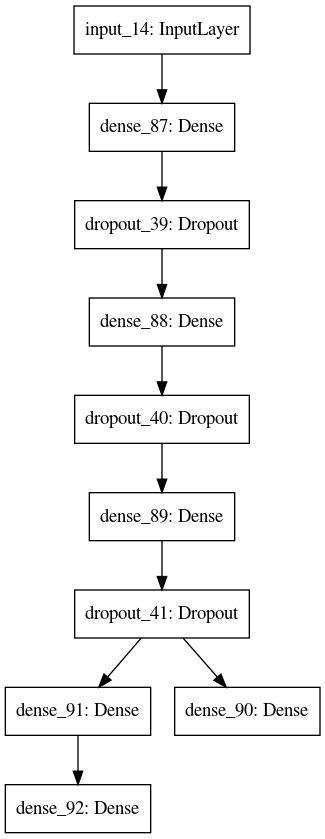

In [359]:
tf.keras.utils.plot_model(model)

In [68]:
test_features = pd.read_pickle("test_features.pkl")

In [69]:
scaled_test_features = minmax.transform(test_features)
scaled_test_features = scaled_test_features+1
scaled_test_features = np.nan_to_num(scaled_test_features)-1 

In [70]:
all_probs = []
for model in models:
    _,probs = model.predict(scaled_test_features)
    all_probs.append(probs)

In [78]:
probs_mean = np.dstack(all_probs).mean(axis=2)

In [79]:
probs = pd.DataFrame(probs_mean, columns=colums)

In [80]:
probs["Outlier"] = 0

In [81]:
probs.index = test_features.index

In [82]:
probs.index.name = "challenge_oid"

In [91]:
probs.to_csv("hierarchical_mlp_v4.csv")

In [84]:
_,old_probs = model.predict(scaled_features)
old_probs = pd.DataFrame(old_probs, columns=colums)
old_probs["Outlier"] = 0 
old_probs.index = features.index
old_probs.index.name = "challenge_oid"

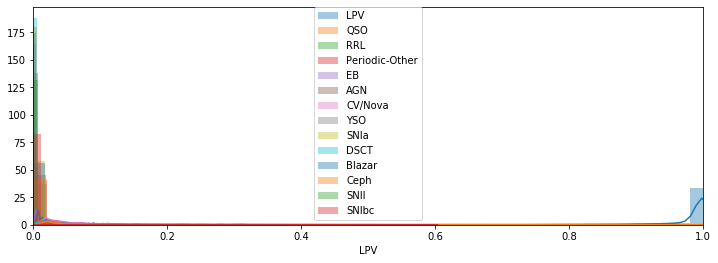

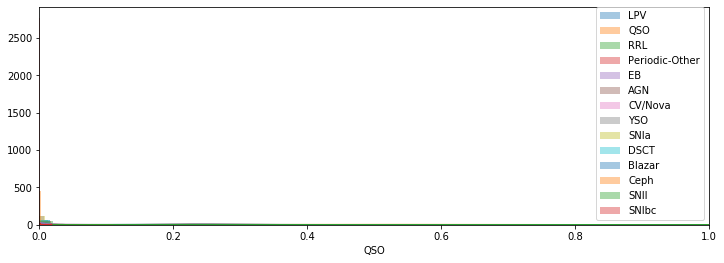

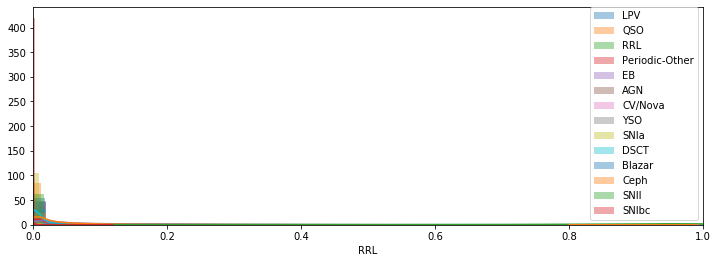

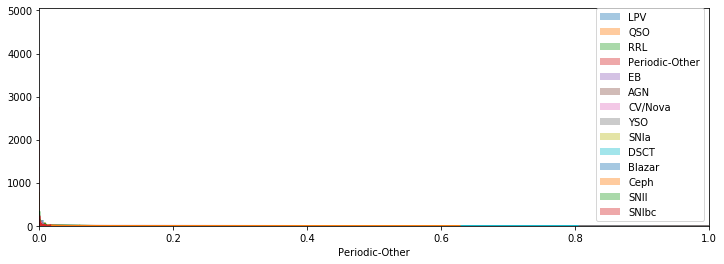

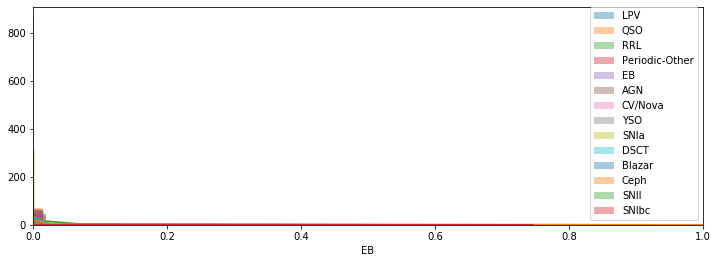

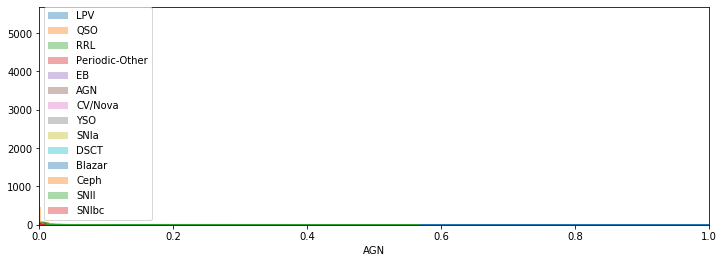

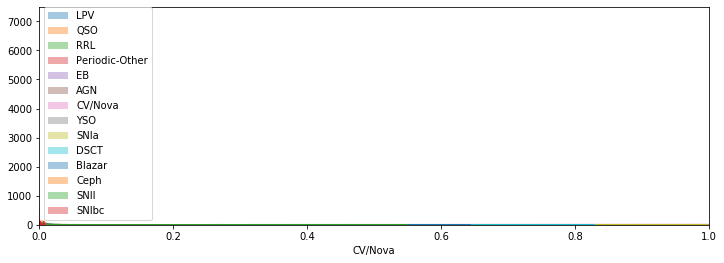

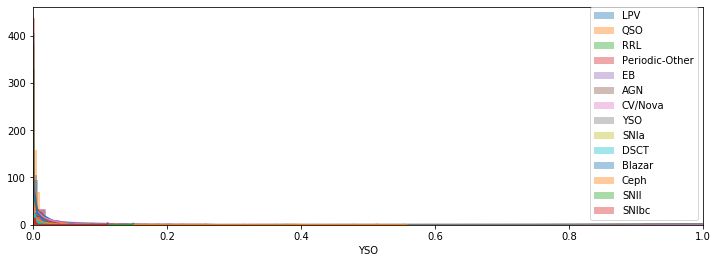

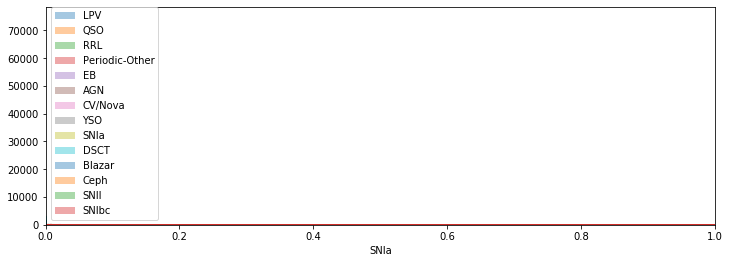

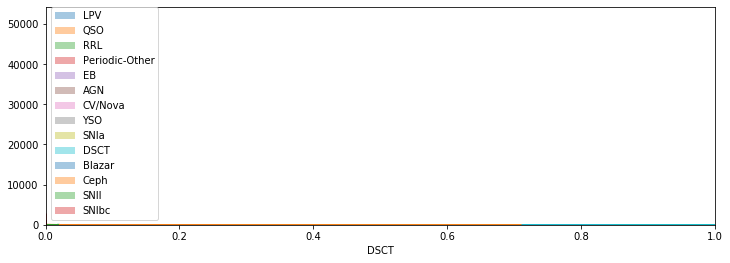

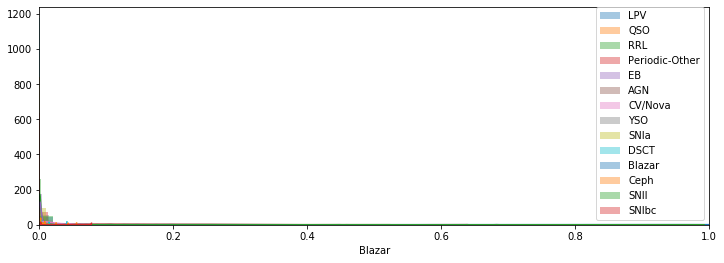

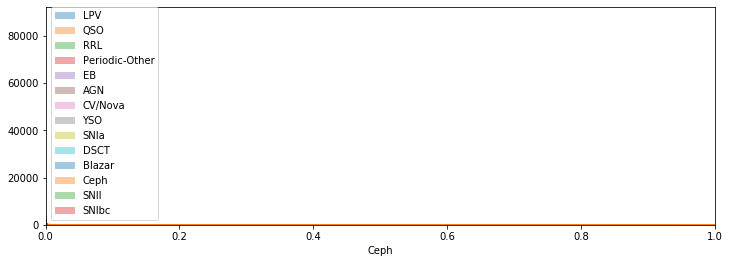

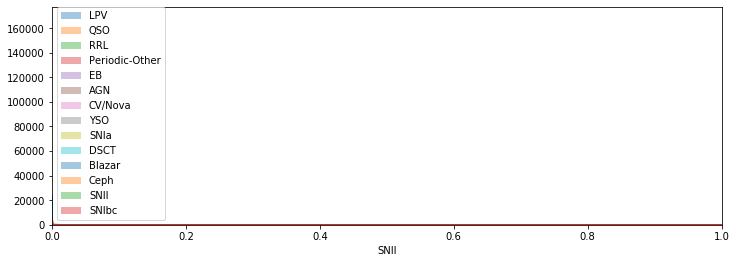

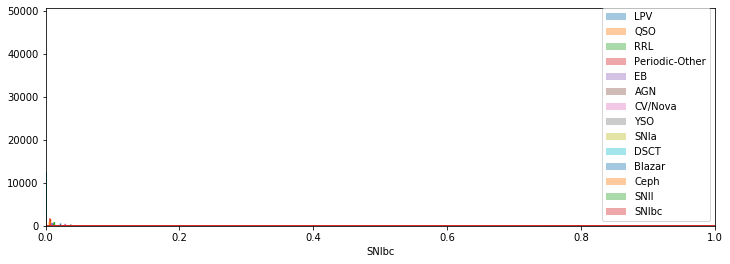

In [85]:
classes = labels
for c in classes.unique():
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    for cj in classes.unique():
        sns.distplot(old_probs[classes == c][cj],ax=ax,label=cj)
    ax.set_xlim((0,1))
    ax.set_xlabel(c)
    ax.legend()
    plt.show()

In [86]:
pred_class = old_probs.idxmax(axis=1)

In [87]:
from sklearn.metrics import confusion_matrix

In [88]:
cm = confusion_matrix(labels.loc[pred_class.index].values, pred_class.values)

In [89]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


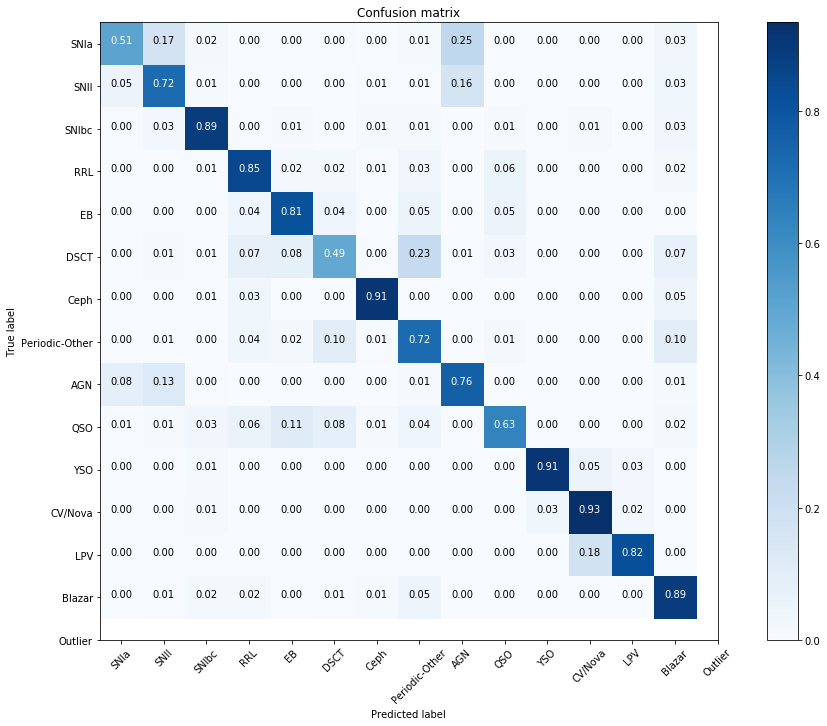

In [90]:
plt.figure(figsize = (14, 10))
plot_confusion_matrix(cm, old_probs.columns,normalize=True)